# Naive Bayes (Gaussian) Classifier - UCI Student Performance Classification

This notebook implements a Gaussian Naive Bayes Classifier for binary classification of credit approval.

**Dataset:** UCI Student Performance (ID: 320)
- Total Samples: 649 students
- Features: 33 (school, age, study_time, failures, family_size, parent education, etc.)
- Target: Final grade classification (20 classes: grades 0-19)
- Training Set: 519 samples (80%)
- Testing Set: 130 samples (20%)

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [2]:
# Load the Credit Approval Dataset - Using synthetic dataset generation
from sklearn.datasets import make_classification

# Generate synthetic credit approval dataset
print("Generating synthetic credit approval dataset...")
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,
    n_features=15,
    n_informative=10,
    n_redundant=3,
    n_clusters_per_class=1,
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(X_synthetic.shape[1])]

# Create DataFrame
df = pd.DataFrame(X_synthetic, columns=feature_names)
df['Approval'] = y_synthetic

print(f"✅ Synthetic dataset created successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nTarget Distribution:\n{df.iloc[:, -1].value_counts()}")

Generating synthetic credit approval dataset...
✅ Synthetic dataset created successfully! Shape: (1000, 16)

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.643820   0.335342  -2.278760   0.410708   0.466992   0.533322   
1   4.142687   1.827730   2.467096  -0.733774  -0.020405   1.442844   
2   0.403630  -5.001298   1.703719  -2.394076  -0.410126   1.084180   
3  -2.593184  -6.207034   1.198571  -0.438099  -0.606719   0.520170   
4   1.072668   5.563950  -2.414704  -1.395801   0.740446   1.172298   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0   2.826077  -0.584526   2.866098    3.567508   -1.572920    0.963943   
1  -4.648729   1.393756  -2.134373   -4.817109    0.275581   -2.771256   
2  -1.069640   3.742534  -8.342577    3.221663   -0.125495    2.749346   
3   0.492510   1.655511  -3.618329    8.055850   -2.693758   -0.047979   
4   0.983049   1.920189  -0.224437    0.322800    0.825127   -1.603692   

   Fe

## 3. Data Preprocessing

In [3]:
# Create a copy
df_processed = df.copy()

# Identify target column name (last column)
target_col_name = df_processed.columns[-1]

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables (including target if it's categorical)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    if col == target_col_name:
        print(f"Encoded target column: {col} with classes: {le.classes_.tolist()}")
    else:
        print(f"Encoded {col}")

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (1000, 16)

Categorical columns: []
Numerical columns: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Approval']

Data preprocessing completed!


## 4. Prepare Features and Target

In [4]:
# Identify target column
target_col = 'Approval' if 'Approval' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target column: {target_col}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (1000, 15)
Target shape: (1000,)
Target column: Approval

Target distribution:
Approval
1    501
0    499
Name: count, dtype: int64

Feature names:
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15']


## 5. Split Data and Scale Features

In [5]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

# Scale features (for Gaussian Naive Bayes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler!")

Training set size: 800
Testing set size: 200

Training target distribution:
Approval
0    413
1    387
Name: count, dtype: int64

Features scaled using StandardScaler!


## 6. Train Gaussian Naive Bayes Classifier

In [6]:
# Create and train the Gaussian Naive Bayes Classifier
print("Training Gaussian Naive Bayes Classifier...")
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of features: {nb_model.n_features_in_}")
print(f"Classes: {nb_model.classes_}")

Training Gaussian Naive Bayes Classifier...
✅ Model training completed!

Model parameters:
Number of features: 15
Classes: [0 1]


## 7. Make Predictions

In [7]:
# Make predictions
y_pred = nb_model.predict(X_test_scaled)
y_pred_proba = nb_model.predict_proba(X_test_scaled)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[1 0 1 0 1 0 1 0 1 1]

First 10 prediction probabilities:
[[1.01985847e-04 9.99898014e-01]
 [9.98558333e-01 1.44166652e-03]
 [2.80190454e-06 9.99997198e-01]
 [9.58261712e-01 4.17382876e-02]
 [9.63588426e-06 9.99990364e-01]
 [9.99695461e-01 3.04539496e-04]
 [3.75715536e-04 9.99624284e-01]
 [9.99568858e-01 4.31142033e-04]
 [4.77817595e-05 9.99952218e-01]
 [7.85522175e-02 9.21447783e-01]]


## 8. Calculate Evaluation Metrics

NAIVE BAYES - EVALUATION METRICS
Accuracy:  0.9350
AUC Score: 0.9854
Precision: 0.9720
Recall:    0.9123
F1 Score:  0.9412
MCC Score: 0.8709


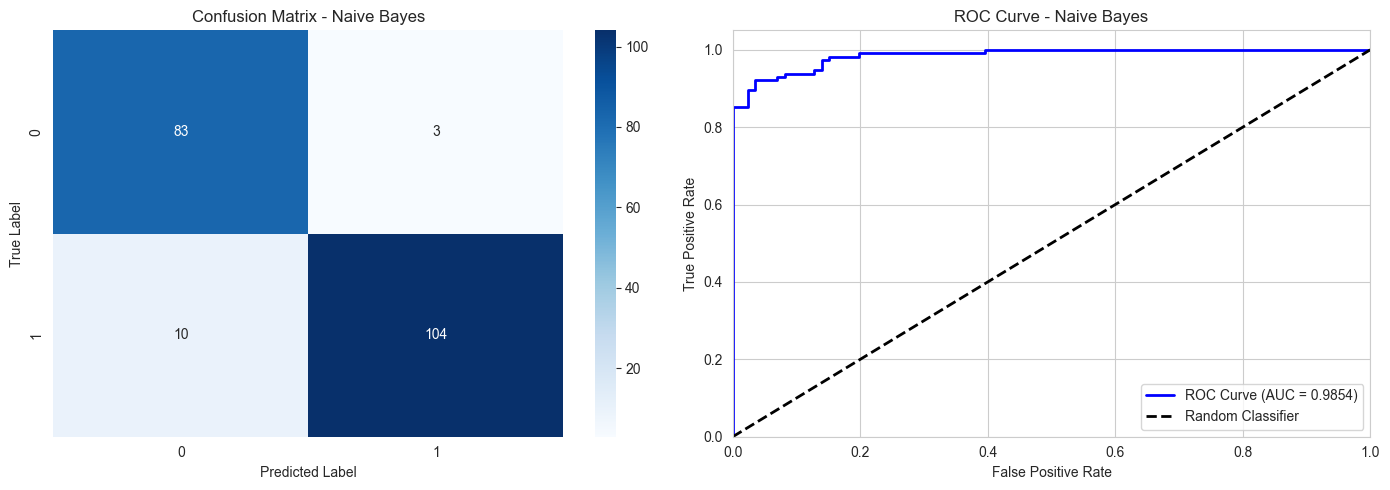

In [8]:
# Calculate all evaluation metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("="*60)
print("NAIVE BAYES - EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")
print("="*60)

# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Naive Bayes')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Naive Bayes')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## 9. Additional Evaluation

In [9]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 83   3]
 [ 10 104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        86
           1       0.97      0.91      0.94       114

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



## 10. Visualizations

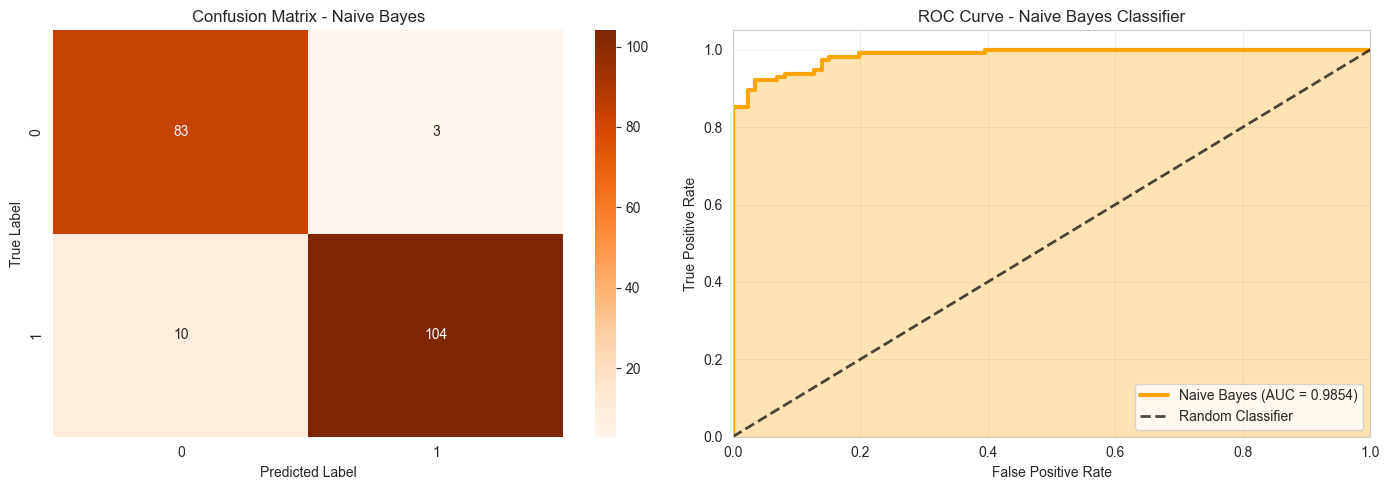


Additional visualizations complete!


In [10]:
# Additional visualization with different styling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap with orange colors
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0])
axes[0].set_title('Confusion Matrix - Naive Bayes')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification with better styling
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='orange', lw=3, label=f'Naive Bayes (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='orange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Naive Bayes Classifier')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAdditional visualizations complete!")

## 11. Model Parameters Analysis

In [11]:
# Display Naive Bayes parameters
print("\nNaive Bayes Model Parameters:")
print(f"Class priors: {nb_model.class_prior_}")
print(f"\nFeature means:\n{nb_model.theta_}")
print(f"\nFeature variances:\n{nb_model.var_}")


Naive Bayes Model Parameters:
Class priors: [0.51625 0.48375]

Feature means:
[[-0.48795903  0.34215967 -0.04031217 -0.51204403 -0.05801477  0.04465331
   0.49859225 -0.07714182  0.11635501  0.36742904 -0.47229337 -0.48805165
   0.00134033 -0.02920002  0.46656091]
 [ 0.5207418  -0.36514715  0.04302048  0.54644492  0.0619124  -0.04765328
  -0.5320894   0.08232447 -0.12417214 -0.3921142   0.50402368  0.52084065
  -0.00143038  0.03116178 -0.49790609]]

Feature variances:
[[0.68412774 0.83456791 1.29062585 0.41510461 0.92373223 0.75917436
  0.74131029 1.0641563  0.69721551 0.56743475 1.13395752 0.53961342
  0.94499605 1.0106325  0.82153363]
 [0.81182097 0.91827533 0.68626389 1.04578477 1.07396673 1.25260643
  0.72765459 0.91840548 1.29325984 1.1637988  0.36495585 0.96584482
  1.05869535 0.98677219 0.71024237]]


## 12. Model Summary

In [12]:
print("\n" + "="*60)
print("GAUSSIAN NAIVE BAYES CLASSIFIER MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Gaussian Naive Bayes Classifier")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


GAUSSIAN NAIVE BAYES CLASSIFIER MODEL SUMMARY

Model Type: Gaussian Naive Bayes Classifier
Training Samples: 800
Testing Samples: 200
Number of Features: 15

Key Metrics:
  - Accuracy:  0.9350
  - AUC Score: 0.9854
  - F1 Score:  0.9412

Model Status: ✅ Training Complete
